# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import random
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble      import RandomForestRegressor

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## Neural networks parameters

In [3]:
Lag        =   12
Horizon    =    2

# Data handling

## Import data


In [4]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Data concern the concentration from a mine in Norway
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

 

# # Parameters
#
filename   = '../metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'



# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.39 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


In [5]:
# # Parameters
# #
# filename   = '../Data/D-6-It.csv'

# Transformation  = True
# Scaling         = 'Standard'




# # Start timer
# #
# start = time.time()

# # Load data
# #
# df = pd.read_csv(filename, 
#                  sep = ',')


# # Rename columns
# #
# df = df.rename(columns = {'created_at' : 'Date',
#                           'field1' : 'Temperature',
#                           'field2' : 'Humidity',
#                           'field3' : 'PM2.5',
#                           'field4' : 'PM10',
#                           'field5' : 'NO2',
#                           'field6' : 'CO',
#                           'field7' : 'NH4',})



# # End timer
# #
# print('[INFO] Time: %.2f' % (time.time() - start))

# df.head( 3 )

## Preprocess data

### Set index

In [6]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('10min').mean()
df = pd.DataFrame( df[ ['CO'] ] )
df.head(3)

,CO
Date,
2022-02-19 00:00:00,240.710526
2022-02-19 00:10:00,227.473684
2022-02-19 00:20:00,229.526316


In [7]:
targetSeries = df.columns[-1]

### Split Training/Testing

In [8]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

### Visualization

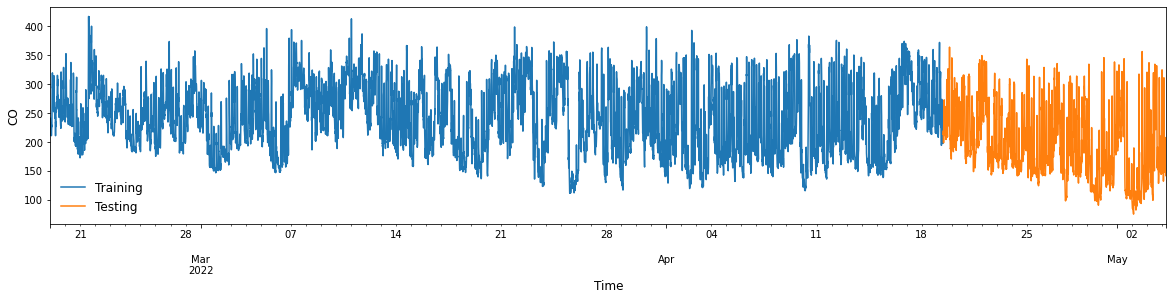

In [9]:
plt.figure( figsize = (20, 4) );
#
df_train[ targetSeries ].plot()
df_test[ targetSeries ].plot()
#
plt.legend(['Training', 'Testing'], fontsize = 12, frameon = False);
plt.ylabel( targetSeries, size = 12);
plt.xlabel( 'Time', size = 12);

### Fixing Lag

In [10]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [11]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(abs( -df.min().min() ) + 1.0, 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)

    # # Transformation parameter
    # #
    # d = {'parameter': VALUE}

    # import json
    # with open('checkpoints/Transformation.json', 'w') as fp:
    #     json.dump(d, fp)
    # print('[INFO] Parameters saved')

else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


In [13]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
     
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    # Set scaler
    #
    scaler = StandardScaler()

    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )  


# # Save Scaler
# #
# import pickle
# filename = 'checkpoints/Target_scaler.pkl'
# pickle.dump(scaler, open(filename, 'wb'))
# print('[INFO] Target scaler saved in ', filename)      

[INFO] Scaling: Standard


## Create Training/Testing data

In [14]:
def create_dataset(df, look_back=1, Horizon = 1, SeriesName ='', overlap = 1):
    
    # Check if SeriesName exists in dataset
    #
    if (SeriesName not in df.columns):
        SeriesName = df.columns[-1]
    
    
    date, dataX, dataY = [], [], []

    for i in tqdm( range(0, df.shape[0] + 1  - look_back - Horizon, overlap) ):
                    
        # Check for NaN values
        if (df[i:i + Lag + Horizon].dropna().shape[0] != df[i:i + Lag + Horizon].shape[0]): continue
                
        data = df[i:(i+look_back+Horizon)].copy()
        # Not sequental interval
        #
        if (data.reset_index().diff()[1:].nunique()['Date'] > 1): continue
         
        # X
        #
        # Lag-Instances from Target Series
#         A = data[ SeriesName ].to_numpy()[:look_back].flatten()        
#         # Information from other features (only from current time)
#         B = data.iloc[look_back-1, data.columns != SeriesName].to_numpy()
#         # Concatenate all information - Instance created
#         dataX.append( np.concatenate([A, B]) )
        
#         dataX.append( data[ SeriesName ].to_numpy()[:look_back].flatten() )



        A = data[ SeriesName ].to_numpy()[:look_back].flatten()[-3:]
        # Information from Moving-Average features
        B = np.array([
                       data[:look_back][ SeriesName ].to_numpy()[-4:].mean(),
                       data[:look_back][ SeriesName ].to_numpy()[-7:].mean(),
                       data[:look_back][ SeriesName ].to_numpy().mean(),     
                       #
                       data[:look_back][ SeriesName ].to_numpy()[-4:].std(),
                       data[:look_back][ SeriesName ].to_numpy()[-7:].std(), 
                       data[:look_back][ SeriesName ].to_numpy().std(),     
                       #
                       np.sin( data.index.hour[look_back] + data.index.minute[look_back] / 60.0 ),
                       np.cos( data.index.hour[look_back] + data.index.minute[look_back] / 60.0 )
                      ])
        # Concatenate all information - Instance created
        dataX.append( np.concatenate([A, B]) )



        # ALL DATA: dataX.append( data.to_numpy()[:look_back].flatten() )


        # Y
        #
        dataY.append( data[ SeriesName ].to_numpy()[ look_back : look_back + Horizon] )
        
        # Date (ahead) - Needed for visualization
        #
        date.append( data.index[ look_back : look_back + Horizon] )
                      
    return ( np.array(dataX), np.array(dataY), np.array(date) )

In [15]:
trainX, trainY, _ = create_dataset(df           = df_train, 
                                   look_back    = Lag, 
                                   Horizon      = Horizon, 
                                   SeriesName   = targetSeries,
                                   overlap      = 1,
                                   )

testX,  testY, _  = create_dataset(df           = df_test, 
                                   look_back    = Lag, 
                                   Horizon      = Horizon, 
                                   SeriesName   = targetSeries,
                                   overlap      = Horizon,)



print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 1070/1070 [00:03<00:00, 280.02it/s]

Training instances:     8545
Testing instances:      1070


# Forecasting model: RF

## Setup model

In [16]:
model = RandomForestRegressor(n_jobs = -1, random_state = 42)

## Training process

In [17]:
# Start clock
#
start = time.time()

# Train model
#
model.fit(trainX, trainY)

# Terminate clock
#
stop = time.time()

print('[INFO] Time %.2f' % (stop - start))

[INFO] Time 1.15


## Evaluation

### Get predictions

In [18]:
# Get predictions
#
pred = model.predict( testX )


# # Get prediction of each component tree
# #
# predictions = []
# for Tree in model.estimators_:
#     predictions += [ Tree.predict( testX ) ]
    
# predictions = np.array( predictions )

In [19]:
# Features = ['Feature-{}'.format(i) for i in range(trainX.shape[1])]
# import seaborn as sns

# # Feature importance
# #
# Feature_importances = 100 * model.feature_importances_ / model.feature_importances_.sum()
# feature_imp         = pd.DataFrame(sorted(zip(Feature_importances, Features)), columns = ['Importance', 'Feature'])



# # Histogram - Feature importance
# #
# plt.figure(figsize  = (15, 8))
# sns.barplot(x       = "Importance", 
#             y       = "Feature", 
#             palette = "vlag",
#             data    = feature_imp.sort_values(by="Importance", ascending=False))


# plt.title('Features');

### Apply inverse scaling/transformation

In [20]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred = np.exp( pred )   - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [26]:
Results = dict()

for i in range( Horizon ):
    Prices = pd.DataFrame( [] )

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]
    

        
    # Store results
    #
    Results[ 'Horizon {}'.format(i+1) ] = Prices



sResults = {'MAE': [], 'RMSE': [], 'MAPE': [], 'SMAPE': [], 'R2': []}

for i in range(Horizon):
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Results['Horizon {}'.format(i+1)] )
    
    sResults['MAE']   += [MAE]
    sResults['RMSE']  += [RMSE]
    sResults['MAPE']  += [MAPE]
    sResults['SMAPE'] += [SMAPE]
    sResults['R2']    += [R2]
    
    
#     print('Horizon -%i-' % (i+1))
#     print('--------------')
#     print('MAE   = %.3f' % MAE)
#     print('RMSE  = %.3f' % RMSE)
#     print('MAPE  = %.3f' % MAPE)
#     print('SMAPE = %.3f' % SMAPE)
#     print('R2    = %.3f' % R2)
#     print()
    print('Horizon: %2i MAE %5.2f RMSE %5.2f SMAPE: %5.2f R2: %.2f' % (i+1, MAE, RMSE, SMAPE, R2) )

Horizon:  1 MAE 16.75 RMSE 25.01 SMAPE:  8.61 R2: 0.83
Horizon:  2 MAE 26.95 RMSE 37.77 SMAPE: 13.73 R2: 0.63


### Reliability evaluation

[INFO] Feature:  CO
------------------------------------------------


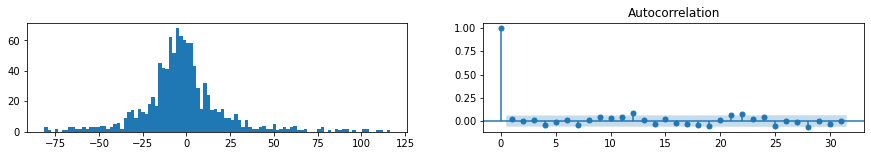

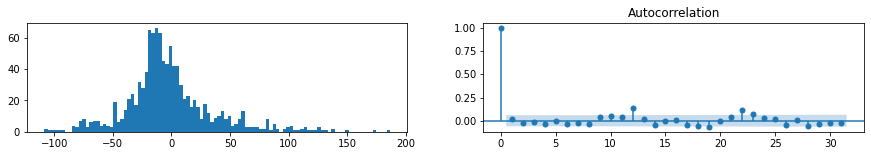

In [22]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]
    
            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices[targetSeries] - Prices['Prediction']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )       

## Visualization of Predictions

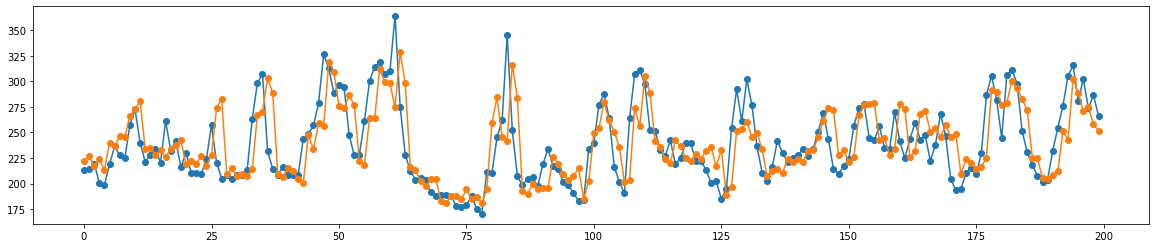

In [23]:
Prices = pd.DataFrame( [] )

Prices[targetSeries] = testY.flatten()
Prices['Prediction'] = pred.flatten()


# Plot results
#
plt.figure( figsize = (20, 4) );
#
Prices[ targetSeries ][:200].plot(color = 'tab:blue', marker = 'o')
Prices[ 'Prediction' ][:200].plot(color = 'tab:orange', marker = 'o')
plt.show();


### Examples

In [24]:
# subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
# plt.figure( figsize = (20, 8) )
# RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]
# RandomInstances = [66, 62, 192, 448, 477, 1035, 55, 408, 860]

# for plot_id, i in enumerate(RandomInstances):

#     plt.subplot(subplots[plot_id])
#     plt.grid()

#     plt.plot(testY[i], color='g', marker = 'o', linewidth = 2)
#     plt.plot(pred[i],  color='r', marker = 'o', linewidth = 2)

#     plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
#     plt.ylim([90, 260])
# plt.show()

# Store errors

In [25]:
Outputs = pd.DataFrame([])
#
#
Outputs[targetSeries] = testY.flatten()
Outputs['RF']         = pred.flatten()
#
Outputs.to_csv('Predictions/RF.csv')